In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
qc = QuantumCircuit(3)
qc.h(2)
qc.draw()

q_0: ─────
          
q_1: ─────
     ┌───┐
q_2: ┤ H ├
     └───┘

In [3]:
qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.draw()

q_0: ──────────────
                   
q_1: ──────■───────
     ┌───┐ │P(π/2) 
q_2: ┤ H ├─■───────
     └───┘

In [4]:
qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.draw()

q_0: ───────────────■───────
                    │       
q_1: ──────■────────┼───────
     ┌───┐ │P(π/2)  │P(π/4) 
q_2: ┤ H ├─■────────■───────
     └───┘

In [5]:
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw()

┌───┐
q_0: ───────────────■─────────────■───────┤ H ├
                    │       ┌───┐ │P(π/2) └───┘
q_1: ──────■────────┼───────┤ H ├─■────────────
     ┌───┐ │P(π/2)  │P(π/4) └───┘              
q_2: ┤ H ├─■────────■──────────────────────────
     └───┘

In [6]:
qc.swap(0,2)
qc.draw()

┌───┐   
q_0: ───────────────■─────────────■───────┤ H ├─X─
                    │       ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────■────────┼───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/2)  │P(π/4) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

In [7]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)

In [8]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

q_0: ──────■─────────────────────────
           │                         
q_1: ──────┼────────■────────────────
           │        │                
q_2: ──────┼────────┼────────■───────
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) 
q_3: ┤ H ├─■────────■────────■───────
     └───┘

In [9]:
# from qiskit_textbook.widgets import scalable_circuit
# scalable_circuit(qft_rotations)

In [10]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

┌───┐
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├
           │                               │                ┌───┐ │P(π/2) └───┘
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■────────────
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘              
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■──────────────────────────
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────
     └───┘

In [11]:
# scalable_circuit(qft_rotations)

In [12]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw()

┌───┐»
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├»
           │                               │                ┌───┐ │P(π/2) └───┘»
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X──»
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘           │  »
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■───────────────────────X──»
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     »
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────»
     └───┘                                                                     »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«

In [13]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘

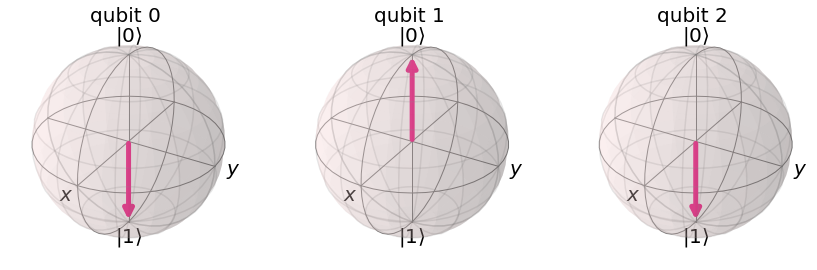

In [14]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [15]:
qft(qc,3)
qc.draw()

┌───┐                                     ┌───┐   
q_0: ┤ X ├──────■──────────────────────■───────┤ H ├─X─
     └───┘      │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ───────────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ X ├┤ H ├─■────────■───────────────────────────X─
     └───┘└───┘

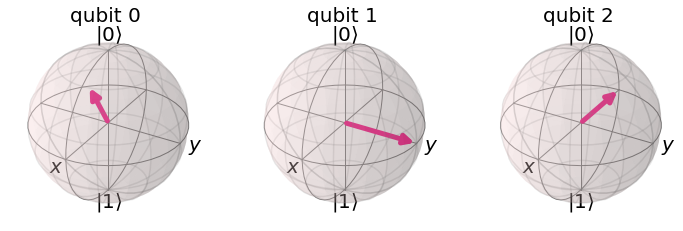

In [16]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

In [17]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [18]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

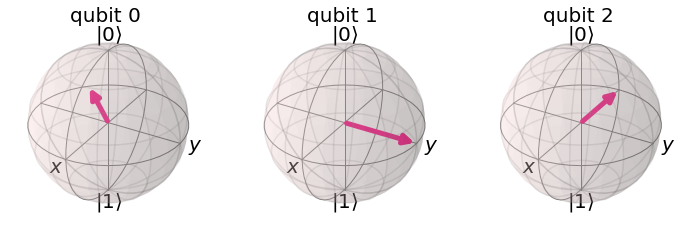

In [19]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [20]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐   ┌───┐                                   »
   q_0: ┤ U2(0,π) ├┤ U(0,0,5π/4) ├─X─┤ H ├─■────────────────────────■────────»
        ├─────────┤├─────────────┤ │ └───┘ │P(-π/2) ┌───┐           │        »
   q_1: ┤ U2(0,π) ├┤ U(0,0,5π/2) ├─┼───────■────────┤ H ├─■─────────┼────────»
        ├─────────┤└┬───────────┬┘ │                └───┘ │P(-π/2)  │P(-π/4) »
   q_2: ┤ U2(0,π) ├─┤ U(0,0,5π) ├──X──────────────────────■─────────■────────»
        └─────────┘ └───────────┘                                            »
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«              ░ ┌─┐      
«   q_0: ──────░─┤M├──────
«              ░ └╥┘┌─┐   
«   q_1: ──────░──╫─┤M├───
«        ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├─░──╫──╫─┤M├
«        └───┘ ░  ║  ║ └╥┘
«meas: 3/═════════╩══╩══╩═
«                 0  1  2

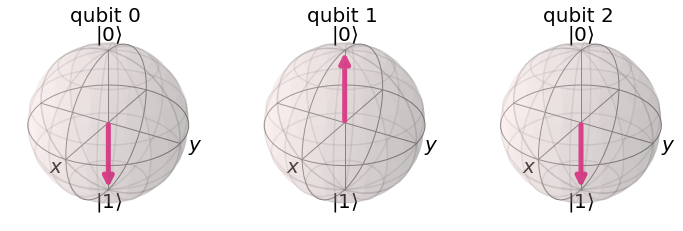

In [21]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)